<center><h1 style="background: linear-gradient(to right, #dd3030, #aa60ff); padding: 5px; color: white;">
    ACTIVIDAD 1 CURSO PROYECTO DE APLICACIÓN (Parte 3) Análisis Exploratorio de Datos (EDA)
</h1></center>

**DATOS:** Factores Continuidad Educación Superior de Nariño (Kaggle)

**ESTUDIANTE:** Jesús Armando Pérez Ovalle

**No. CEDULA:** 1122650728


# 1. Contexto de la investigación

Este estudio se hizo con el objetivo de identificar y analizar las características socioeconómicas, demográficas, territoriales y académicas que afectan la transición y permanencia en la educación superior en Nariño, mediante un modelo de clasificación binaria basado en machine learning. Para ello se empleó un enfoque cuantitativo utilizando modelos de clasificación binaria, como regresión logística, árboles de decisión y bosques aleatorios, para predecir si un estudiante accederá a la educación superior (y_target). El estudio se basó en el conjunto de datos "Factores Continuidad Educación Superior de Nariño" de Kaggle, que fue limpiado y procesado en un notebook de Jupyter usando Python, eliminando valores nulos y codificando variables categóricas. Los datos se dividieron en conjuntos de entrenamiento y prueba, y los modelos se evaluaron mediante métricas como precisión, recall y F1-score. Los resultados preliminares identifican las variables clave que determinan la probabilidad de continuidad educativa y proporcionan una herramienta predictiva útil para diseñar políticas educativas.

# 2. Necesidad del estudio

El acceso y permanencia en la educación superior son fundamentales para el desarrollo local. Comprender los factores que limitan o facilitan la continuidad permitirá diseñar intervenciones informadas que reduzcan la desigualdad educativa y aumenten las oportunidades en la región.

# 3. Hipótesis

Se plantea la hipótesis de que variables como el nivel socioeconómico, rendimiento académico previo, ubicación geográfica (rural/urbana) y tipo de institución de procedencia influyen de manera significativa en la probabilidad de continuidad en la educación superior.

# 4. Descripción de los datos

El dataset contiene variables de tipo numérico (por ejemplo: edad, puntajes, ingresos) y categórico (por ejemplo: género, zona de residencia, tipo de institución). La variable objetivo indica continuidad o no en la educación superior.


In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns; sns.set_theme()
from IPython.display import Markdown, display
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification
from sklearn.metrics import classification_report
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from pycaret.datasets import get_data
from pycaret.classification import *

Se muestran las columnas del archivo **.csv**

In [3]:
cols = pd.read_csv("factores_narino.csv", nrows=0).columns
print(f'Falta {6-len(cols)%6} variable(s) para poder crear una matriz rectangular')

Falta 1 variable(s) para poder crear una matriz rectangular


In [4]:
cols_2 = np.append(cols, '-')
n = 6
display(pd.DataFrame(np.array(cols_2).reshape(-1, n)))

,0,1,2,3,4,5
0,estu_consecutivo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_cod_icfes
1,cole_cod_mcpio_ubicacion,cole_depto_ubicacion,cole_genero,cole_jornada,cole_mcpio_ubicacion,cole_naturaleza
2,cole_nombre_establecimiento,cole_nombre_sede,cole_sede_principal,cole_valor_pension,desemp_c_naturales,desemp_ingles
3,desemp_lectura_critica,desemp_matematicas,desemp_sociales_ciudadanas,estu_antecedentes,estu_area_reside,estu_cod_depto_presentacion
4,estu_cod_mcpio_presentacion,estu_cod_reside_depto,estu_cod_reside_mcpio,estu_dedicacioninternet,estu_dedicacionlecturadiaria,estu_depto_presentacion
5,estu_estadoinvestigacion,estu_fechanacimiento,estu_genero,estu_horas_trabaja,estu_ies_cod_deseada,estu_inse_individual
6,estu_mcpio_presentacion,estu_nacimiento_anno,estu_nacionalidad,estu_pais_reside,estu_privado_libertad,estu_puesto
7,estu_reside_depto,estu_reside_mcpio,estu_tipo_documento,estu_tiporemuneracion,estu_trabaja,estu_vecespresentoexamen
8,fami_automovil,fami_celular,fami_comecarnepescadohuevo,fami_comecerealfrutoslegumbre,fami_comelechederivados,fami_computador
9,fami_cuartos_hogar,fami_dvd,fami_educa_madre,fami_educa_padre,fami_estrato_vivienda,fami_horno


Para explorar los determinantes de la continuidad educativa tras la secundaria, se seleccionaron variables de carácter sociocultural y escolar que, según la literatura y el razonamiento causal, pueden influir en la probabilidad de que un estudiante siga y culmine una carrera técnica o profesional. Se incluyen características individuales (género, dedicación a internet y a la lectura, horas de trabajo, puesto escolar), familiares (nivel educativo de la madre y del padre) y de la institución educativa (área de ubicación, naturaleza, bilingüismo). Estas variables capturan tanto los recursos culturales y educativos disponibles en el hogar como las oportunidades y limitaciones del contexto escolar. El propósito es identificar los factores que favorecen o dificultan la transición hacia estudios superiores, entendiendo esta trayectoria como un proceso socialmente determinado por el capital cultural, las condiciones económicas y las características de la institución educativa.

Variables del contexto **Sociocultural** del estudiante a utilizar en la investigación

**Familiar y económico (hogar):** fami_educa_madre, fami_educa_padre, fami_lee_escribe_madre, fami_lee_escribe_padre, fami_ocupa_madre, fami_ocupa_padre, fami_ingreso_fmiliar_mensua, fami_estrato_vivienda, fami_nivel_sisben, fami_situacioneconomica, fami_num_hermanos, fami_personas_hogar, fami_cuartos_hogar.

**Bienes y capital cultural:** fami_computador, fami_internet, fami_numlibros, fami_automovil, fami_motocicleta, fami_nevera, fami_lavadora, fami_horno, fami_microondas, fami_telefono_fijo, fami_dvd, fami_servicio_television.

**Personal y sociodemográfico:** estu_genero, estu_trabaja, estu_horas_trabaja, estu_tiporemuneracion, estu_dedicacioninternet, estu_dedicacionlecturadiaria, estu_nacionalidad.

**Escolar (institución y entorno):** cole_area_ubicacion, cole_naturaleza, cole_bilingue, cole_jornada, cole_calendario, cole_caracter, cole_genero, cole_valor_pension.

In [5]:
variables = [
    'estu_consecutivo', 'fami_lee_escribe_madre', 'fami_lee_escribe_padre', 'fami_ocupa_madre', 'fami_ocupa_padre', 'fami_ingreso_fmiliar_mensual',
    'fami_estrato_vivienda', 'fami_nivel_sisben', 'fami_situacioneconomica', 'fami_num_hermanos', 'fami_personas_hogar', 'fami_cuartos_hogar',
    'fami_computador', 'fami_internet', 'fami_numlibros', 'fami_automovil', 'fami_motocicleta', 'fami_nevera', 'fami_lavadora', 'fami_horno',
    'fami_microondas', 'fami_dvd', 'fami_servicio_television', 'estu_genero', 'estu_trabaja', 'estu_horas_trabaja', 'estu_tiporemuneracion',
    'estu_dedicacioninternet', 'estu_dedicacionlecturadiaria', 'estu_nacionalidad', 'cole_area_ubicacion', 'cole_naturaleza', 'cole_bilingue',
    'cole_jornada', 'cole_calendario', 'cole_caracter', 'cole_genero', 'cole_valor_pension', 'estu_puesto', 'presentosabertyt', 'presentosaberPRO',
    'presentoPruebas'
]

In [6]:
df = pd.read_csv("factores_narino.csv", usecols = variables, low_memory=False)

In [7]:
print(f'Datos cargados: \n Filas: {df.shape[0]}, columnas: {df.shape[1]}')

Datos cargados: 
 Filas: 221532, columnas: 42


Se verifica que la columna presentoP representa que presento al menos una prueba: presentosabertyt o presentosaberPRO.

In [8]:
var = df.columns
print(f'Variables a comparar: {var[-3]}, {var[-2]}, {var[-1]}')
sum(['SI' if i == 'SI' or j == 'SI' else 'NO' for i,j in zip(df[var[-3]], df[var[-2]])] == df[var[-1]]) == len(df)

Variables a comparar: presentosabertyt, presentosaberPRO, presentoPruebas


True

In [9]:
Markdown(
    f'Se verifica que efectivamente todas las filas (**{df.shape[0]}**) cumplen con la hipótesis.'
    f'Por lo tanto solo se va a trabajar con la variable **presentoPruebas**.'
)

Se verifica que efectivamente todas las filas (**221532**) cumplen con la hipótesis.Por lo tanto solo se va a trabajar con la variable **presentoPruebas**.

In [10]:
df.drop(columns = ['presentosabertyt', 'presentosaberPRO'], inplace = True)

Se verifican si hay estudiantes que han presentado más de una vez alguna prueba; las cuales serian datos duplicadas en la variable **'estu_consecutivo'**

In [11]:
df['estu_consecutivo'].duplicated().sum()

22

Se muestran las primeras filas para ver la estructura de los datos

In [12]:
df.head(10)

,estu_consecutivo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_genero,cole_jornada,cole_naturaleza,cole_valor_pension,estu_dedicacioninternet,...,fami_nevera,fami_nivel_sisben,fami_num_hermanos,fami_numlibros,fami_ocupa_madre,fami_ocupa_padre,fami_personas_hogar,fami_servicio_television,fami_situacioneconomica,presentoPruebas
0,SB11201220182294,RURAL,NO,A,TECNICO/ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,...,No,Nivel 1,S/D,S/D,Empleado de nivel auxiliar o administrativo,Trabajador por cuenta propia,7,No,SIN,SI
1,SB11201320048231,URBANO,NO,A,ACADEMICO,MIXTO,MAÑANA,NO OFICIAL,Entre 150.000 y menos de 250.000,S/D,...,Si,No está clasificada por el SISBEN,S/D,S/D,Trabajador por cuenta propia,Trabajador por cuenta propia,5,No,SIN,SI
2,SB11201320459557,URBANO,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,...,Si,Nivel 1,S/D,S/D,Hogar,Empleado obrero u operario,6,No,SIN,SI
3,SB11201710024293,URBANO,NO,B,TECNICO/ACADEMICO,MIXTO,MAÑANA,NO OFICIAL,S/D,Entre 1 y 3 horas,...,S/D,S/D,S/D,26 A 100 LIBROS,"Trabaja como profesional (por ejemplo médico, ...","Trabaja como profesional (por ejemplo médico, ...",4,Si,Igual,SI
4,SB11201710024293,URBANO,NO,B,TECNICO/ACADEMICO,MIXTO,MAÑANA,NO OFICIAL,S/D,Entre 1 y 3 horas,...,S/D,S/D,S/D,26 A 100 LIBROS,"Trabaja como profesional (por ejemplo médico, ...","Trabaja como profesional (por ejemplo médico, ...",4,Si,Igual,SI
5,SB11201520291671,RURAL,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,...,S/D,Nivel 1,1,0 A 10 LIBROS,Hogar,Otra actividad u ocupación,4,No,SIN,SI
6,SB11201020183938,URBANO,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,...,No,Nivel 1,S/D,S/D,Hogar,Trabajador por cuenta propia,4,No,SIN,SI
7,SB11201320271538,URBANO,NO,A,TECNICO/ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,...,No,Nivel 2,S/D,S/D,Hogar,Pequeño empresario,3,No,SIN,SI
8,SB11201120178646,RURAL,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,...,No,Nivel 1,S/D,S/D,Hogar,Otra actividad u ocupación,5,No,SIN,SI
9,SB11201320147335,URBANO,NO,A,ACADEMICO,FEMENINO,MAÑANA,OFICIAL,No paga Pensión,S/D,...,Si,No está clasificada por el SISBEN,S/D,S/D,Empleado de nivel auxiliar o administrativo,Empleado de nivel técnico o profesional,3,Si,SIN,SI


Se observa la presencia de valores 'S/D', los cuales son el equivalente a datos faltantes

Se verifica los registros con datos faltantes con el codigo .isna

In [13]:
nulos = df.isna().sum()
nulos[nulos != 0]

Series([], dtype: int64)

Segun lo anterior, no hay datos faltantes en las variables seleccionadas. Ahora se verifica si existen filas completamente duplicadas.

In [14]:
df.duplicated().sum()

22

Se verifico que los datos duplicados no se deben a que los estudiantes presentaron la prueba más de una vez, sino que realmente se duplicaron esos datos.

## 4.1. Tipos de variables

In [15]:
Markdown(f"El dataset tiene **{df.shape[0]}** filas y **{df.shape[1]}** columnas")

El dataset tiene **221532** filas y **40** columnas

Tipos de variables

In [16]:
print(df.dtypes.value_counts())

object    39
int64      1
Name: count, dtype: int64


Información general del dataset

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 221532 entries, 0 to 221531
Data columns (total 40 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   estu_consecutivo              221532 non-null  object
 1   cole_area_ubicacion           221532 non-null  object
 2   cole_bilingue                 221532 non-null  object
 3   cole_calendario               221532 non-null  object
 4   cole_caracter                 221532 non-null  object
 5   cole_genero                   221532 non-null  object
 6   cole_jornada                  221532 non-null  object
 7   cole_naturaleza               221532 non-null  object
 8   cole_valor_pension            221532 non-null  object
 9   estu_dedicacioninternet       221532 non-null  object
 10  estu_dedicacionlecturadiaria  221532 non-null  object
 11  estu_genero                   221532 non-null  object
 12  estu_horas_trabaja            221532 non-null  object
 13 

In [18]:
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object']).columns

In [19]:
Markdown(f"El dataset presenta **{len(num_cols)}** variable numérica  y **{len(cat_cols)}** variables categóricas")

El dataset presenta **1** variable numérica  y **39** variables categóricas

# 5. Analisis exploratorio de datos

## 5.1. Estadísticas descriptivas

In [20]:
print("\nEstadísticas descriptivas - Variables numéricas:")
display(df[num_cols].describe().T)


Estadísticas descriptivas - Variables numéricas:


,count,mean,std,min,25%,50%,75%,max
estu_puesto,221532.0,233.177392,316.359037,0.0,0.0,0.0,459.0,1000.0


La única variable numérica es **estu_puesto**, en la que se indica que más del 50% de los ex-estudiantes (que han salido del colegio) no culminaron educaci´on superior, ya sea porque no ingresaron o porque al finalizar el año 2020 no habían culminado sus estudios superiores.

Más del 50% de los estudiantes tienen el puesto 0; esto podría significar que no presentaron pruebas, ya que el puesto 1 es mejor que el puesto 1000. Los que presentan la prueba no son clasificados en el puesto 0.

In [21]:
df['estu_puesto'].value_counts()[0]

117019

Se sabe que la variable **estu_puesto** hace referenica al puesto que los estudiantes obtuvieron de la prueba Saber 11 ya que el dataset integra información de las pruebas Saber 11 (examen de estado para educación media) y las pruebas Saber Pro y TyT (exámenes de estado para educación superior).

In [22]:
set([(1, v) if i != 0 else (0, v) for i, v in zip(df['estu_puesto'], df['presentoPruebas'])])

{(0, 'NO'), (0, 'SI'), (1, 'NO'), (1, 'SI')}

Este resultado indica que existen individuos que no tienen puesto pero si presentaron pruebas, las tuplas (0, 'Si') o que si tienen puesto pero no presentaron pruebas, las tuplas (1, 'NO')

In [23]:
pd.Series([(1, v) if i != 0 else (0, v) for i, v in zip(df['estu_puesto'], df['presentoPruebas'])], name = 'conicidencias').value_counts(normalize = True)*100

conicidencias
(0, NO)    52.359930
(1, NO)    33.536013
(1, SI)    13.641370
(0, SI)     0.462687
Name: proportion, dtype: float64

El 0.463% de los estudiantes que no tienen puesto, pero que si presentaron pruebas, indica que posiblemente se ha dado un error al registrar sus puestos. Al ser pocos los casos, se podrían borrar o tratar de imputar el puesto.

In [24]:
print("\nEstadísticas descriptivas - Variables categóricas:")
display(df[cat_cols].describe().T)


Estadísticas descriptivas - Variables categóricas:


,count,unique,top,freq
estu_consecutivo,221532,221510,SB11201420292922,2
cole_area_ubicacion,221532,3,URBANO,133078
cole_bilingue,221532,2,NO,213942
cole_calendario,221532,3,A,167745
cole_caracter,221532,6,ACADEMICO,118344
cole_genero,221532,3,MIXTO,164761
cole_jornada,221532,8,MAÑANA,154082
cole_naturaleza,221532,3,OFICIAL,148184
cole_valor_pension,221532,24,No paga Pensión,89011
estu_dedicacioninternet,221532,6,S/D,158804


## 5.2. Distribución de las variables

Se establecen las columnas numericas y las categoricas

In [25]:
df.iloc[:15, 1:]

,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_genero,cole_jornada,cole_naturaleza,cole_valor_pension,estu_dedicacioninternet,estu_dedicacionlecturadiaria,...,fami_nevera,fami_nivel_sisben,fami_num_hermanos,fami_numlibros,fami_ocupa_madre,fami_ocupa_padre,fami_personas_hogar,fami_servicio_television,fami_situacioneconomica,presentoPruebas
0,RURAL,NO,A,TECNICO/ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,S/D,...,No,Nivel 1,S/D,S/D,Empleado de nivel auxiliar o administrativo,Trabajador por cuenta propia,7,No,SIN,SI
1,URBANO,NO,A,ACADEMICO,MIXTO,MAÑANA,NO OFICIAL,Entre 150.000 y menos de 250.000,S/D,S/D,...,Si,No está clasificada por el SISBEN,S/D,S/D,Trabajador por cuenta propia,Trabajador por cuenta propia,5,No,SIN,SI
2,URBANO,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,S/D,...,Si,Nivel 1,S/D,S/D,Hogar,Empleado obrero u operario,6,No,SIN,SI
3,URBANO,NO,B,TECNICO/ACADEMICO,MIXTO,MAÑANA,NO OFICIAL,S/D,Entre 1 y 3 horas,Entre 30 y 60 minutos,...,S/D,S/D,S/D,26 A 100 LIBROS,"Trabaja como profesional (por ejemplo médico, ...","Trabaja como profesional (por ejemplo médico, ...",4,Si,Igual,SI
4,URBANO,NO,B,TECNICO/ACADEMICO,MIXTO,MAÑANA,NO OFICIAL,S/D,Entre 1 y 3 horas,Entre 30 y 60 minutos,...,S/D,S/D,S/D,26 A 100 LIBROS,"Trabaja como profesional (por ejemplo médico, ...","Trabaja como profesional (por ejemplo médico, ...",4,Si,Igual,SI
5,RURAL,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,S/D,...,S/D,Nivel 1,1,0 A 10 LIBROS,Hogar,Otra actividad u ocupación,4,No,SIN,SI
6,URBANO,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,S/D,...,No,Nivel 1,S/D,S/D,Hogar,Trabajador por cuenta propia,4,No,SIN,SI
7,URBANO,NO,A,TECNICO/ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,S/D,...,No,Nivel 2,S/D,S/D,Hogar,Pequeño empresario,3,No,SIN,SI
8,RURAL,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,S/D,S/D,...,No,Nivel 1,S/D,S/D,Hogar,Otra actividad u ocupación,5,No,SIN,SI
9,URBANO,NO,A,ACADEMICO,FEMENINO,MAÑANA,OFICIAL,No paga Pensión,S/D,S/D,...,Si,No está clasificada por el SISBEN,S/D,S/D,Empleado de nivel auxiliar o administrativo,Empleado de nivel técnico o profesional,3,Si,SIN,SI


In [26]:
numeric_cols = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = df.iloc[:, 1:].select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print("Variables numéricas (%d): %s\n" % (len(numeric_cols), numeric_cols[:10]))
print("Variables categóricas (%d): %s\n" % (len(categorical_cols), categorical_cols[:10]))

Variables numéricas (1): ['estu_puesto']

Variables categóricas (38): ['cole_area_ubicacion', 'cole_bilingue', 'cole_calendario', 'cole_caracter', 'cole_genero', 'cole_jornada', 'cole_naturaleza', 'cole_valor_pension', 'estu_dedicacioninternet', 'estu_dedicacionlecturadiaria']



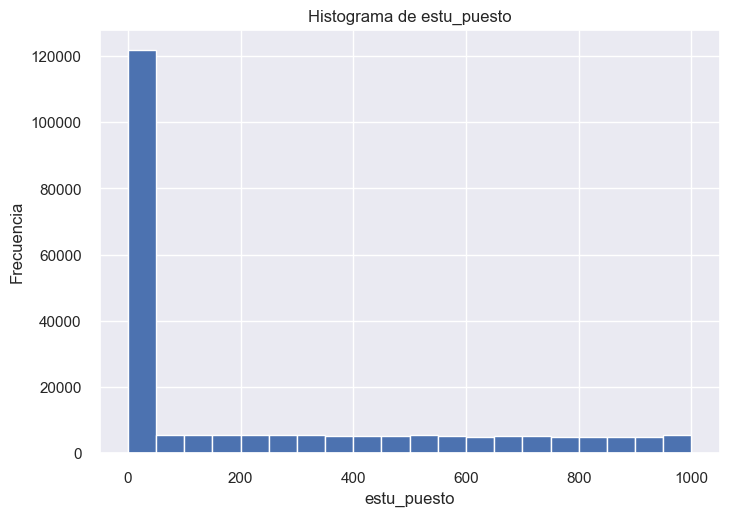

In [27]:
for col in numeric_cols:
    try:
        plt.figure()
        plt.hist(df[col].dropna(), bins=20)
        plt.title(f"Histograma de {col}")
        plt.xlabel(col)
        plt.ylabel("Frecuencia")
        plt.grid(True)
        plt.show()
    except Exception as e:
        print("No se pudo graficar", col, e)

Se observa que la mayoria de los estudiantes no presentaron el ICFES.

In [28]:
import textwrap

In [29]:
def wrap_labels(labels, max_len=20):
    return ['\n'.join(textwrap.wrap(lbl, max_len)) for lbl in labels]

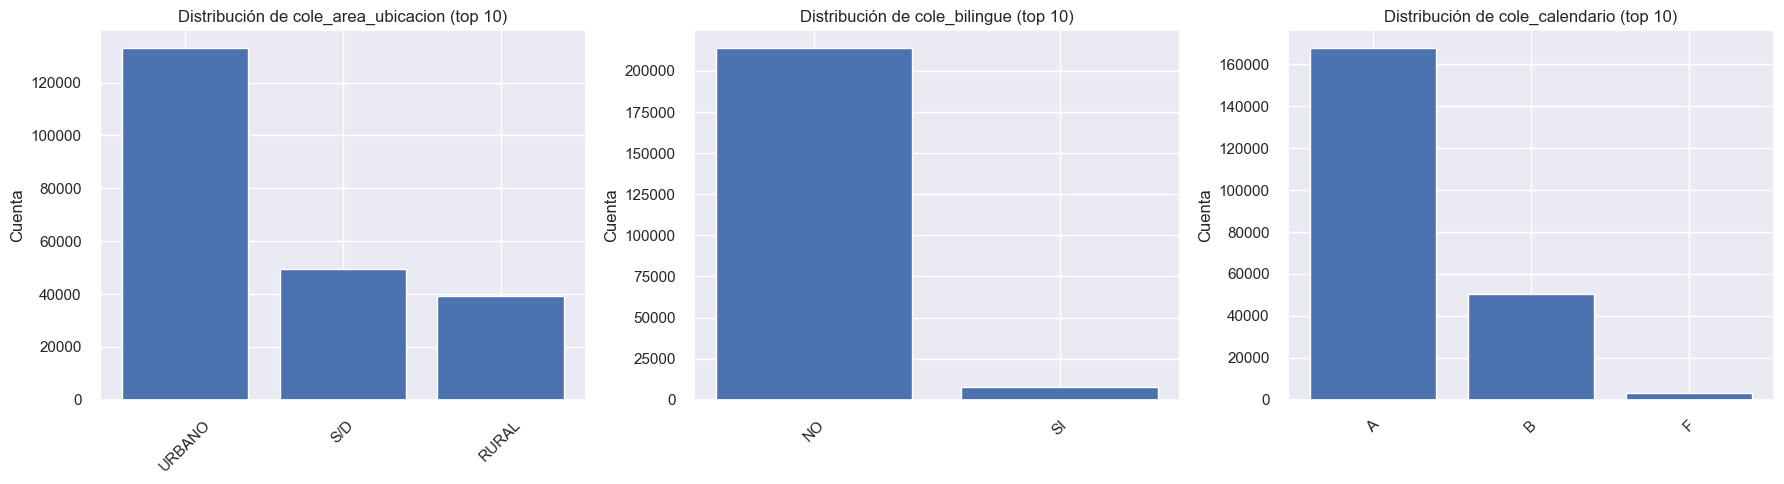

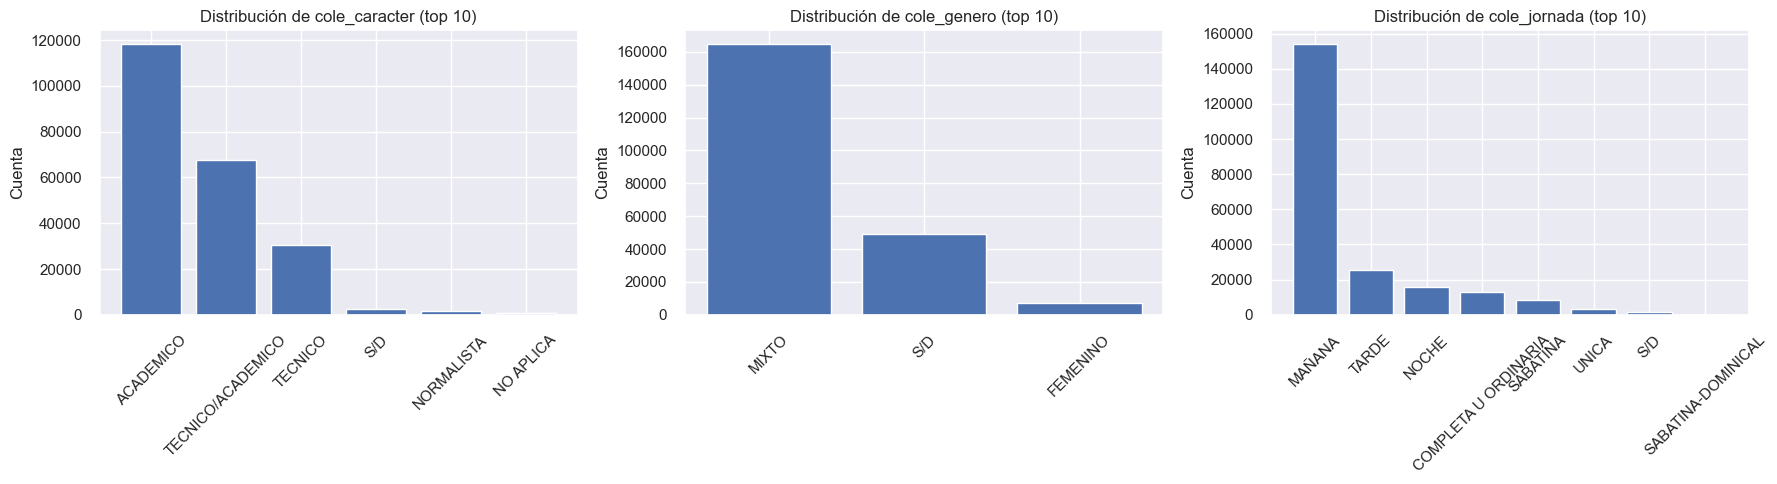

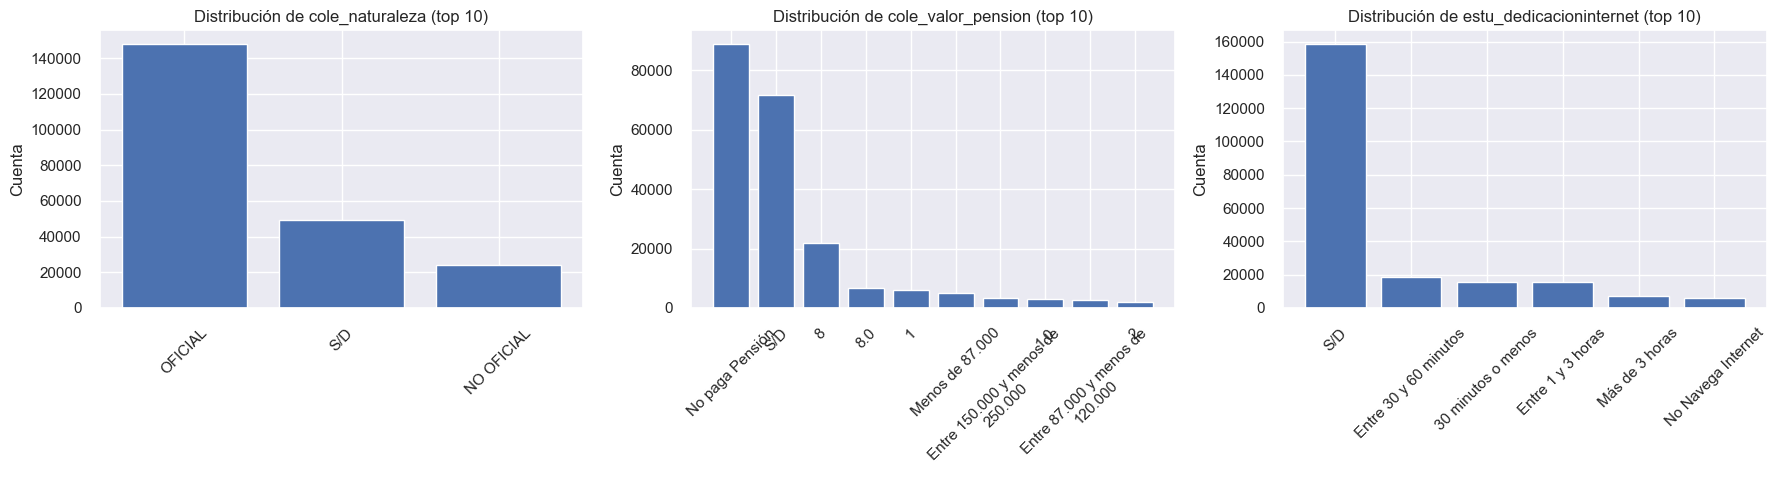

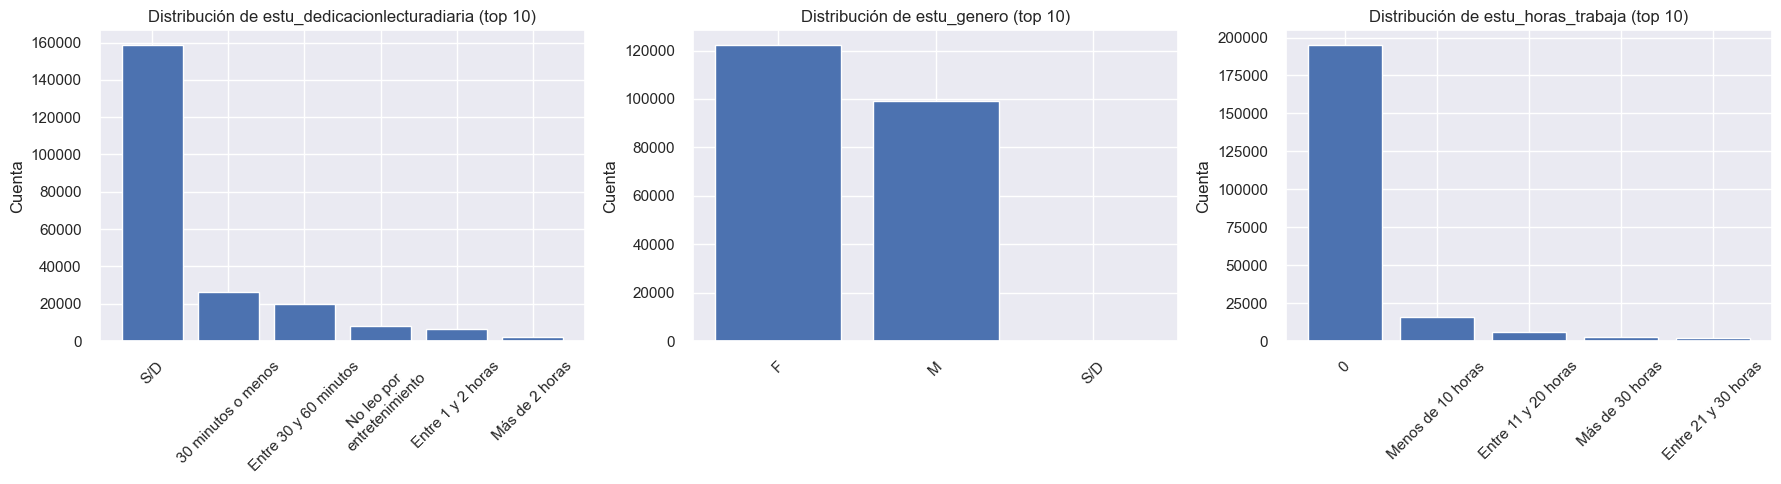

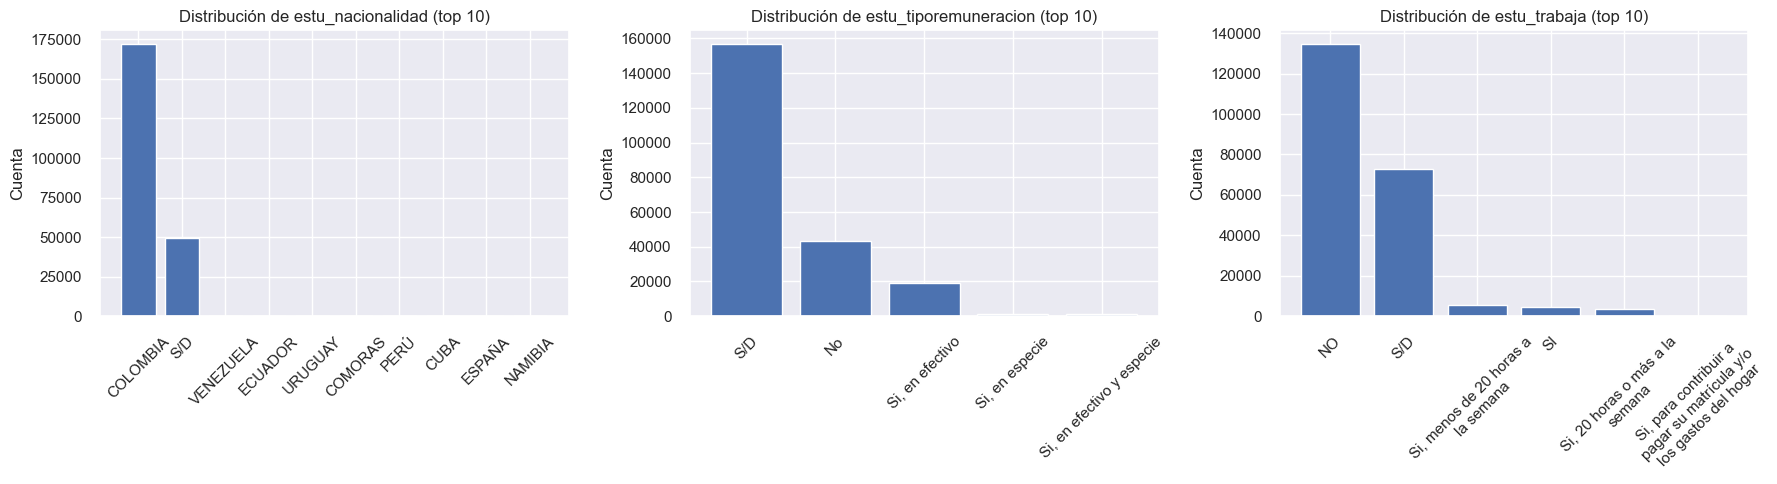

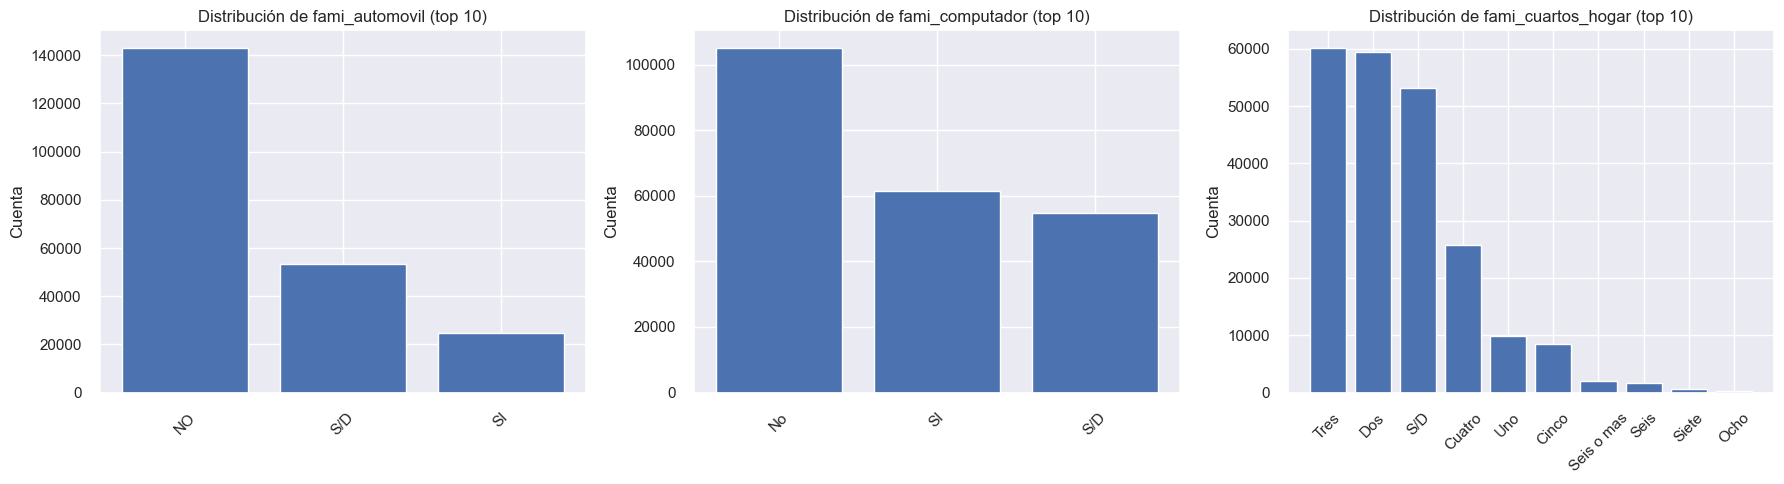

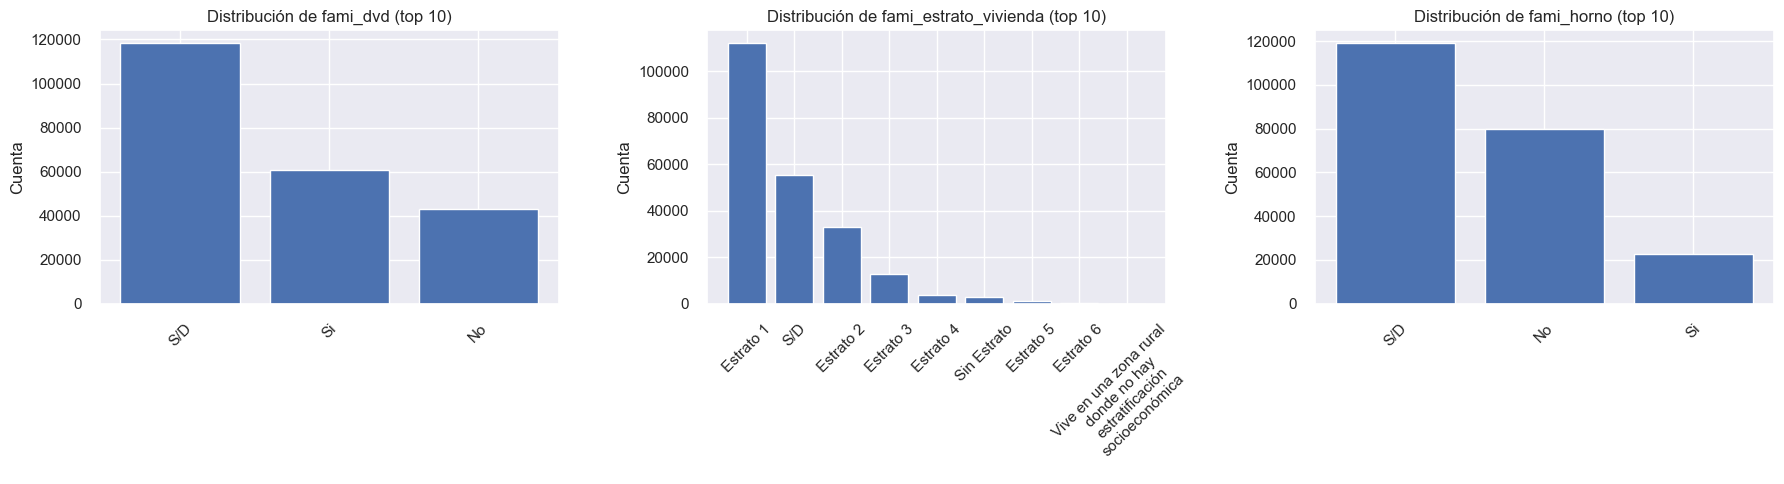

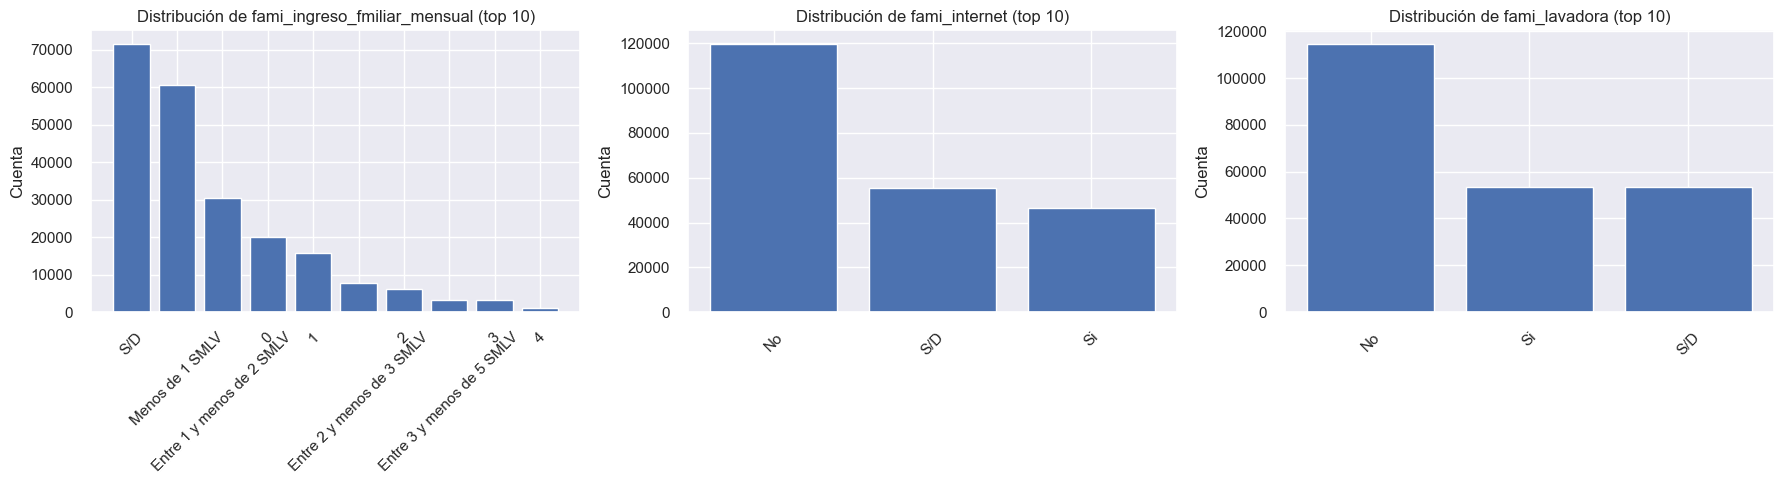

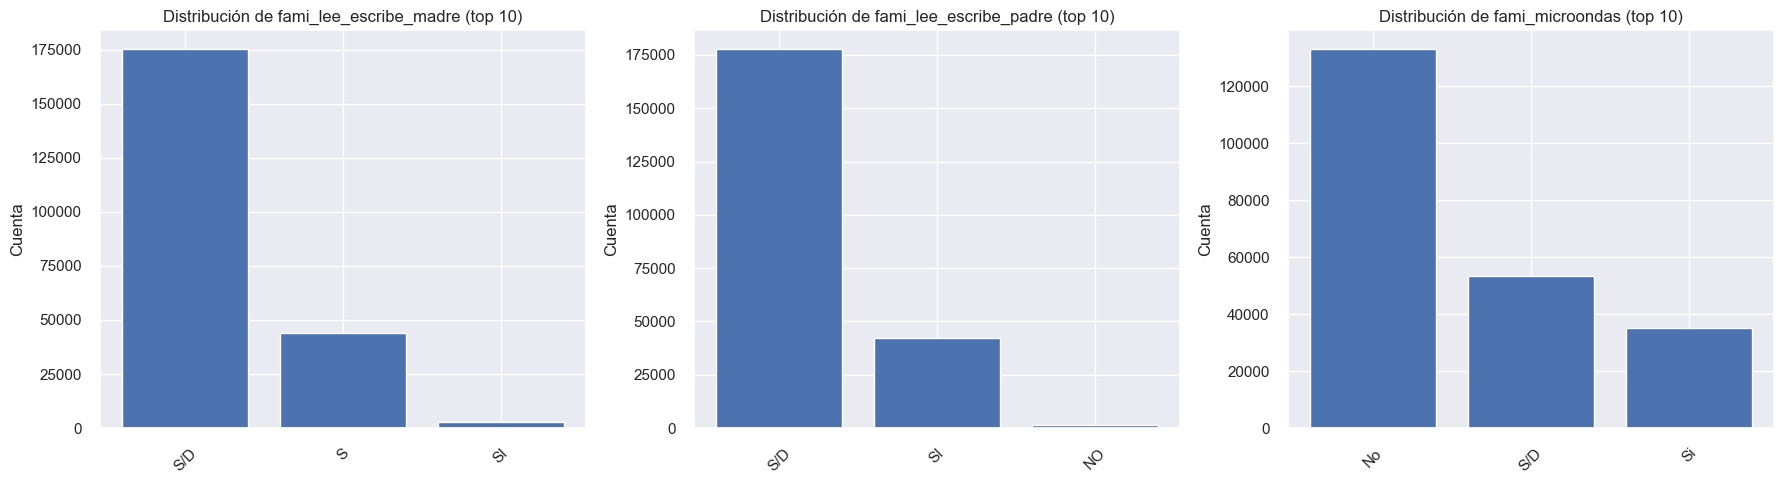

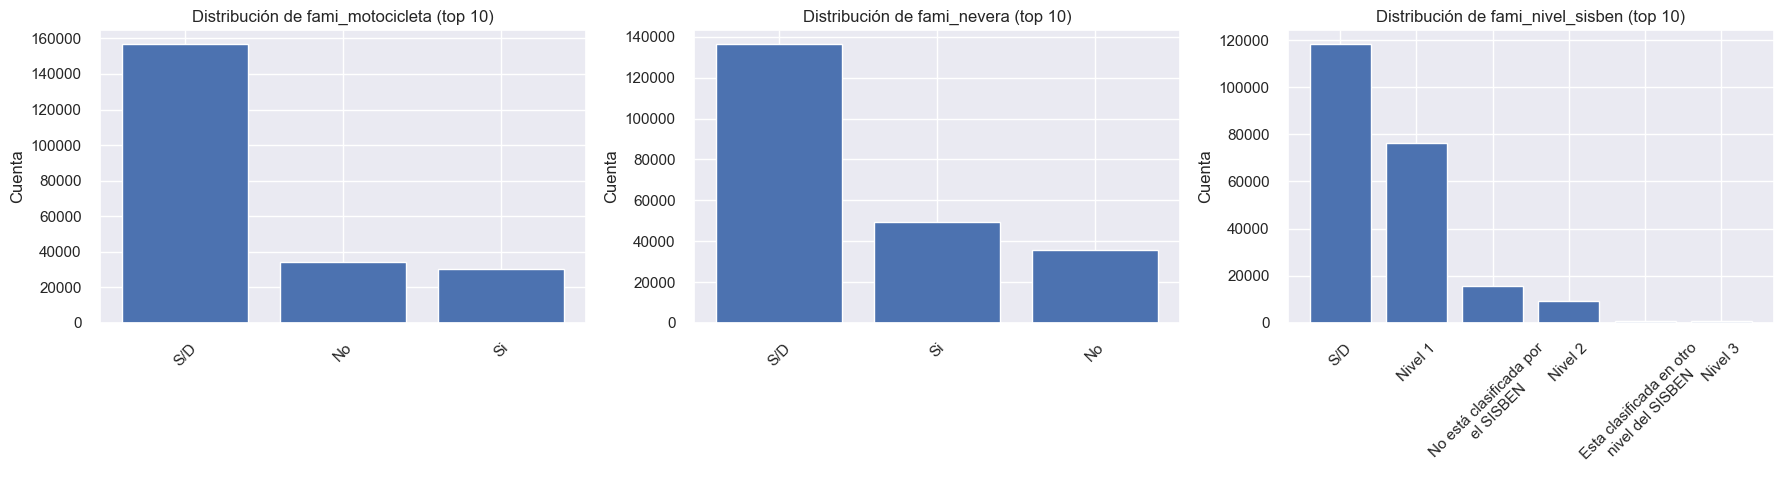

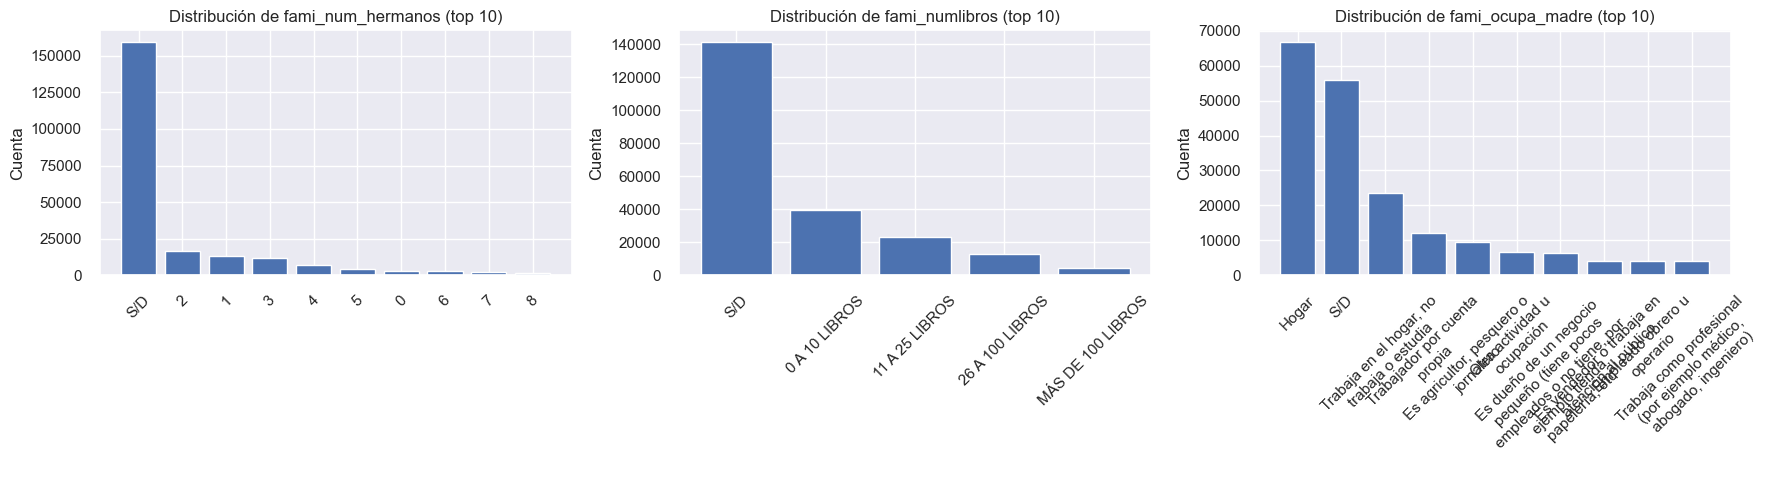

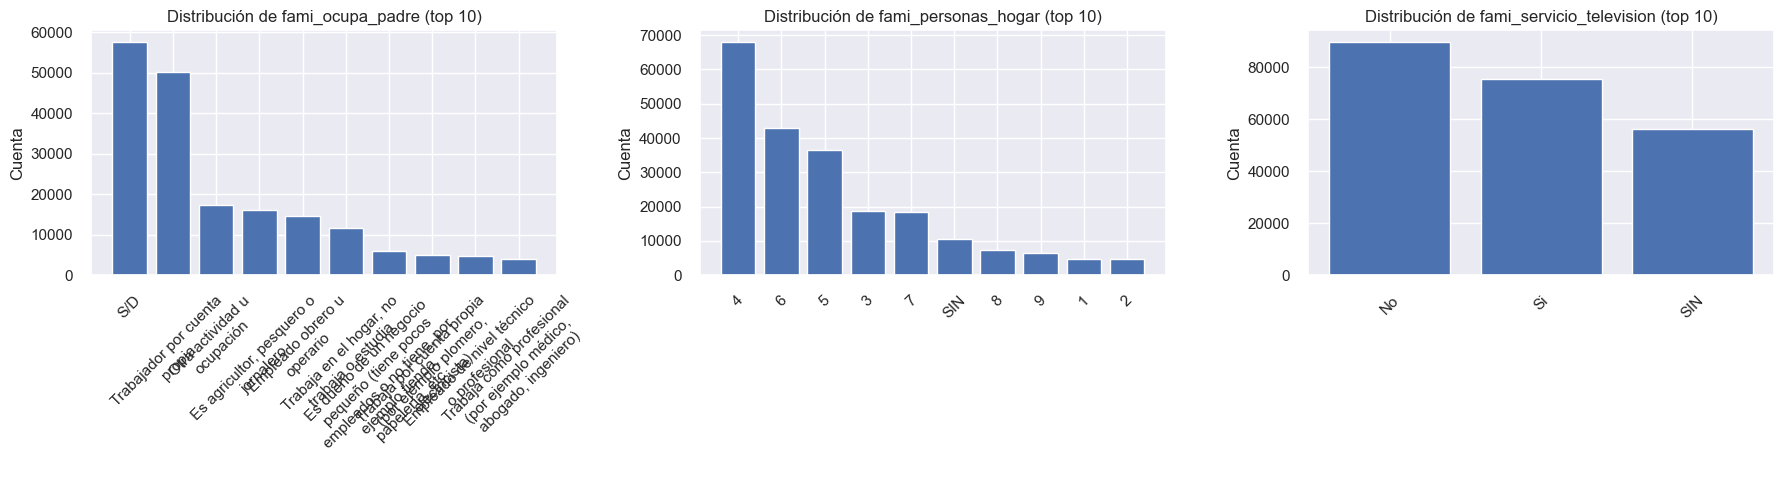

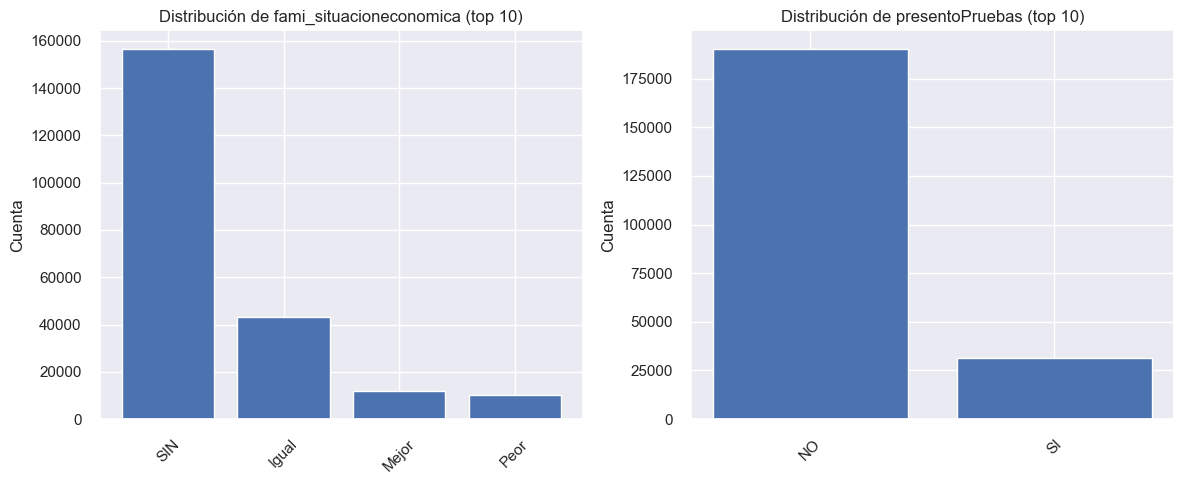

In [30]:
ncols = 3  # 3 gráficas por fila

for i in range(0, len(categorical_cols), ncols):
    subset = categorical_cols[i:i+ncols]  # grupo de 3 columnas
    fig, axes = plt.subplots(1, len(subset), figsize=(6*len(subset), 5))

    # Si solo hay una columna en subset, axes no es lista, lo convertimos en lista
    if len(subset) == 1:
        axes = [axes]

    for ax, col in zip(axes, subset):
        try:
            vc = df[col].value_counts(dropna=False).nlargest(10)
            eti = wrap_labels(vc.index.astype(str), max_len=25)
            ax.bar(eti, vc.values)
            ax.set_title(f"Distribución de {col} (top 10)")
            ax.tick_params(axis="x", rotation=45)
            ax.set_ylabel("Cuenta")
        except Exception as e:
            ax.set_visible(False)
            print("No se pudo graficar", col, e)

    plt.tight_layout()
    plt.show()

Se observa mucha presencia del dato 'S/D' (datos faltantes), lo que indica que multiples variables deben ser borradas 

# 6. Calidad de datos

## 6.1. Imputación de datos

Se análizan los registros duplicados

In [31]:
Markdown(f'El dataset tiene **{df.duplicated().sum()}** dato duplicados, lo que corresponde a los **{df["estu_consecutivo"].duplicated().sum()}**'
f' registros duplicados de la variable  indicadora **estu_conecutivo**')

El dataset tiene **22** dato duplicados, lo que corresponde a los **22** registros duplicados de la variable  indicadora **estu_conecutivo**

Se borran las columnas que tienen datos duplicados ya que presentan porcentajes de datos duplicados muy bajos. Para borrar las variables que tienen datos duplicados:

In [32]:
df.drop_duplicates(inplace = True)

In [33]:
df.shape

(221510, 40)

Se verifico que si se eliminaron las **22** filas duplicadas.

Se muestran las columnas que tiene menos del 10% de datos 'S/D' (equivalente a datos nulos)

In [34]:
display(Markdown(f'Porcentajes de **S/D** por cada columna'))
conteo_por_columna = (df == 'S/D').sum()*100/len(df)
conteo_por_columna = conteo_por_columna[conteo_por_columna < 10]
print(conteo_por_columna)

Porcentajes de **S/D** por cada columna

estu_consecutivo            0.000000
cole_bilingue               0.000000
cole_calendario             0.000000
cole_caracter               1.200849
cole_jornada                0.688457
estu_genero                 0.048756
estu_horas_trabaja          0.000000
estu_puesto                 0.000000
fami_personas_hogar         0.000000
fami_servicio_television    0.000000
fami_situacioneconomica     0.000000
presentoPruebas             0.000000
dtype: float64


In [35]:
for i in df.columns: df[i] = df[i].replace("S/D", np.nan)

In [36]:
df.head(15)

,estu_consecutivo,cole_area_ubicacion,cole_bilingue,cole_calendario,cole_caracter,cole_genero,cole_jornada,cole_naturaleza,cole_valor_pension,estu_dedicacioninternet,...,fami_nevera,fami_nivel_sisben,fami_num_hermanos,fami_numlibros,fami_ocupa_madre,fami_ocupa_padre,fami_personas_hogar,fami_servicio_television,fami_situacioneconomica,presentoPruebas
0,SB11201220182294,RURAL,NO,A,TECNICO/ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,NaN,...,No,Nivel 1,NaN,NaN,Empleado de nivel auxiliar o administrativo,Trabajador por cuenta propia,7,No,SIN,SI
1,SB11201320048231,URBANO,NO,A,ACADEMICO,MIXTO,MAÑANA,NO OFICIAL,Entre 150.000 y menos de 250.000,NaN,...,Si,No está clasificada por el SISBEN,NaN,NaN,Trabajador por cuenta propia,Trabajador por cuenta propia,5,No,SIN,SI
2,SB11201320459557,URBANO,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,NaN,...,Si,Nivel 1,NaN,NaN,Hogar,Empleado obrero u operario,6,No,SIN,SI
3,SB11201710024293,URBANO,NO,B,TECNICO/ACADEMICO,MIXTO,MAÑANA,NO OFICIAL,NaN,Entre 1 y 3 horas,...,NaN,NaN,NaN,26 A 100 LIBROS,"Trabaja como profesional (por ejemplo médico, ...","Trabaja como profesional (por ejemplo médico, ...",4,Si,Igual,SI
5,SB11201520291671,RURAL,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,NaN,...,NaN,Nivel 1,1,0 A 10 LIBROS,Hogar,Otra actividad u ocupación,4,No,SIN,SI
6,SB11201020183938,URBANO,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,NaN,...,No,Nivel 1,NaN,NaN,Hogar,Trabajador por cuenta propia,4,No,SIN,SI
7,SB11201320271538,URBANO,NO,A,TECNICO/ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,NaN,...,No,Nivel 2,NaN,NaN,Hogar,Pequeño empresario,3,No,SIN,SI
8,SB11201120178646,RURAL,NO,A,ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,NaN,...,No,Nivel 1,NaN,NaN,Hogar,Otra actividad u ocupación,5,No,SIN,SI
9,SB11201320147335,URBANO,NO,A,ACADEMICO,FEMENINO,MAÑANA,OFICIAL,No paga Pensión,NaN,...,Si,No está clasificada por el SISBEN,NaN,NaN,Empleado de nivel auxiliar o administrativo,Empleado de nivel técnico o profesional,3,Si,SIN,SI
10,SB11201420313416,URBANO,NO,A,TECNICO/ACADEMICO,MIXTO,MAÑANA,OFICIAL,No paga Pensión,NaN,...,Si,Nivel 1,NaN,NaN,Otra actividad u ocupación,Trabajador por cuenta propia,3,No,SIN,SI


Estas son las variables que se pueden conservar, ya que las demás presentan más del 10% de datos nulos. En 3 variables (cole_caracter, cole_jornada y estu_genero) se requiere imputación de datos. También se elimina la variable **estu_consecutivo** ya que esta solo se tuvo en cuenta para determinar si realmente se tenía datos duplicados, pero no es una variable del componente socio económico.

Reemplazar los valores 'S/D' por valores nulos

In [37]:
import missingno as msno

<Axes: >

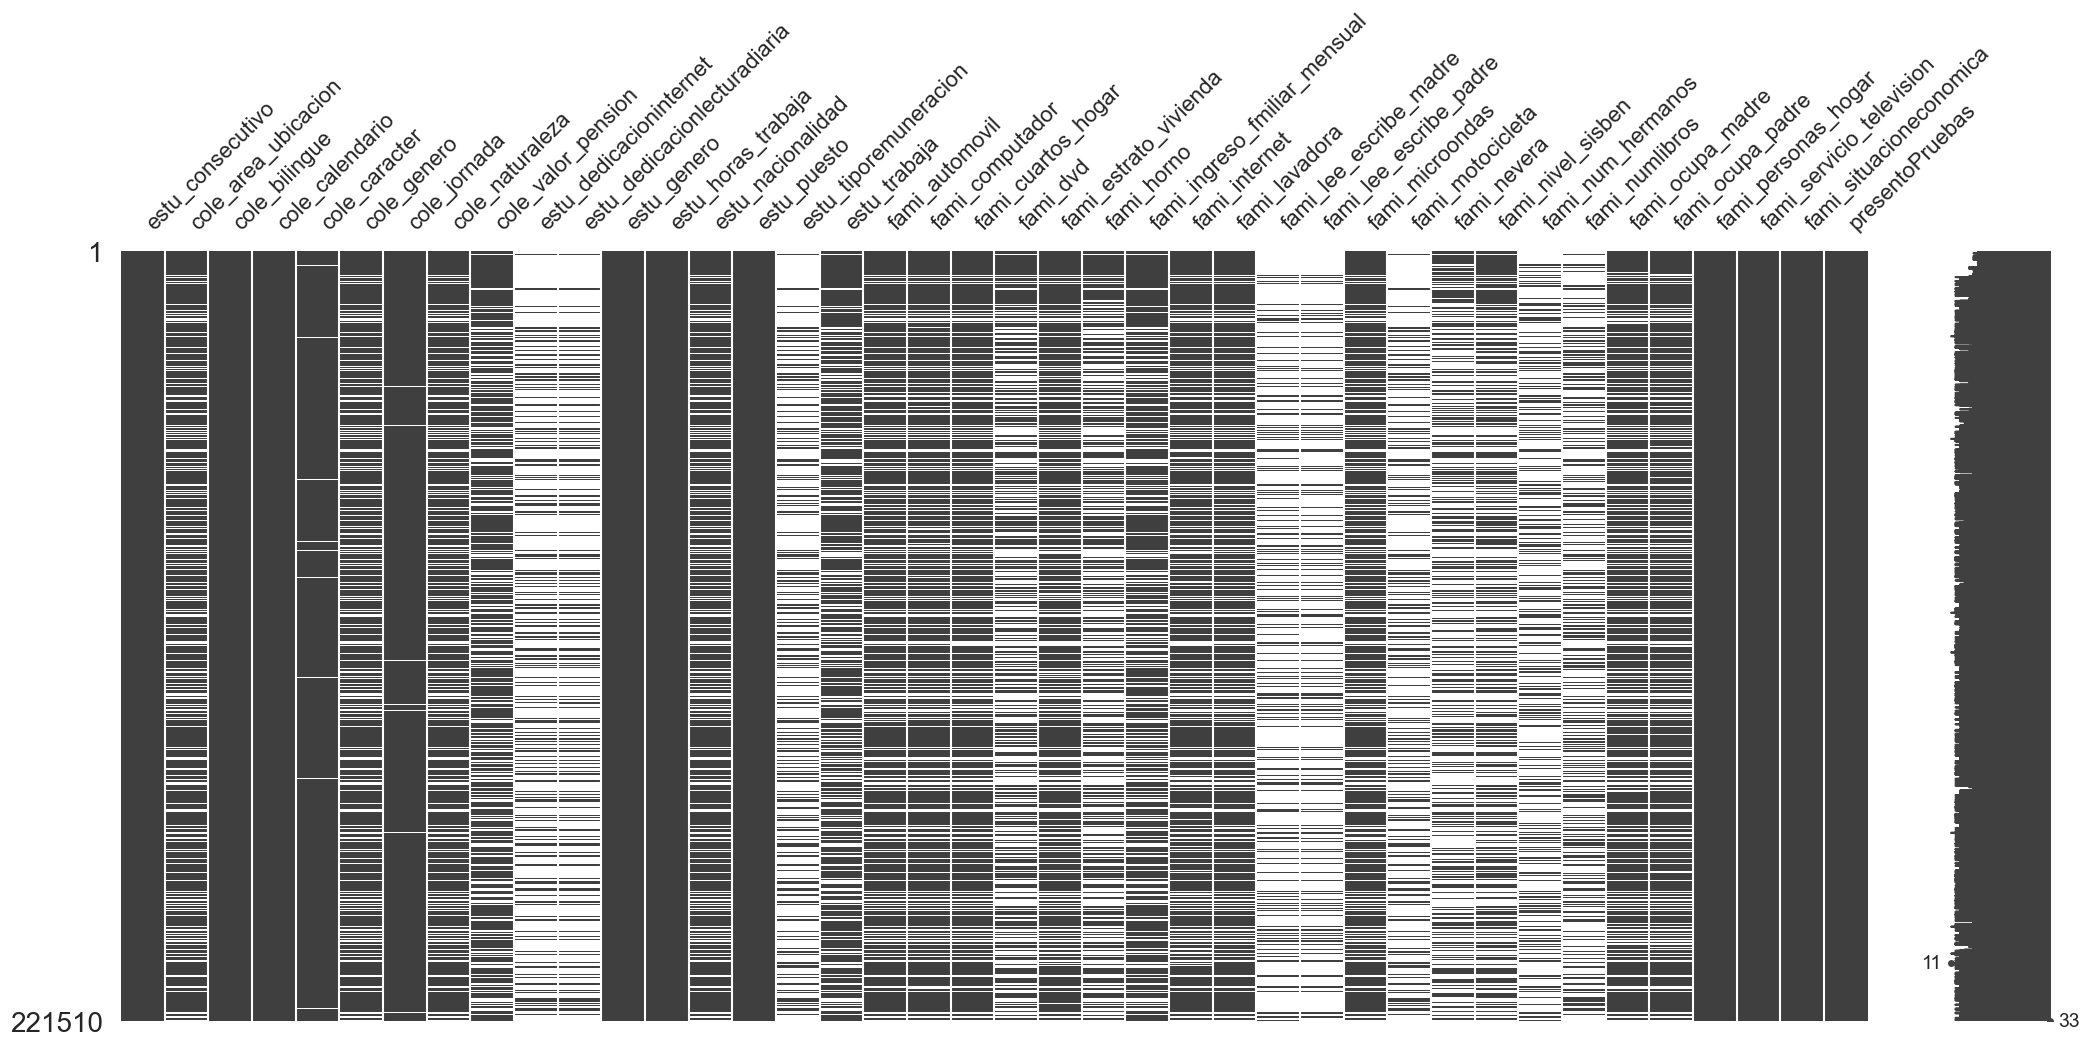

In [38]:
msno.matrix(df)

In [39]:
faltantes = df.isna().sum()*100/len(df)
faltantes[faltantes <= 10]

estu_consecutivo            0.000000
cole_bilingue               0.000000
cole_calendario             0.000000
cole_caracter               1.200849
cole_jornada                0.688457
estu_genero                 0.048756
estu_horas_trabaja          0.000000
estu_puesto                 0.000000
fami_personas_hogar         0.000000
fami_servicio_television    0.000000
fami_situacioneconomica     0.000000
presentoPruebas             0.000000
dtype: float64

In [40]:
df = df[conteo_por_columna.index[1::]]

---

Analisis de las variables que se van a utilizar para el modelo de clasificación

In [41]:
variables = df.columns

---

In [42]:
n=1
variable = variables[n-1]
display(Markdown(f'Analisis de la variable {n}: **{variable}:**'))
print(df[variable].value_counts(normalize = True)*100)

Analisis de la variable 1: **cole_bilingue:**

cole_bilingue
NO    96.57397
SI     3.42603
Name: proportion, dtype: float64


No se requiere tratamiento de las variables

---

In [43]:
n = 2
variable = variables[n-1]
display(Markdown(f'Analisis de la variable {n}: **{variable}:**'))
print(df[variable].value_counts(normalize = True)*100)

Analisis de la variable 2: **cole_calendario:**

cole_calendario
A    75.718929
B    22.850887
F     1.430184
Name: proportion, dtype: float64


No se requiere tratamiento de las variables

---

In [44]:
n = 3
variable = variables[n-1]
display(Markdown(f'Analisis de la variable {n}: **{variable}:**'))
print(df[variable].unique().tolist())
print('\n')
print(df[variable].value_counts(normalize = True)*100)

Analisis de la variable 3: **cole_caracter:**

['TECNICO/ACADEMICO', 'ACADEMICO', 'TECNICO', nan, 'NO APLICA', 'NORMALISTA']


cole_caracter
ACADEMICO            54.070825
TECNICO/ACADEMICO    30.906557
TECNICO              13.945168
NORMALISTA            0.757597
NO APLICA             0.319854
Name: proportion, dtype: float64


Se va a realizar la imputación por medio del **dato anterior** porque es mas probable que los datos de los estudiantes de un colegio se registren en conjunto.

In [45]:
df[variable] = df[variable].replace("NO APLICA", np.nan)

In [46]:
df[variable] = df[variable].ffill()
print(df[variable].unique().tolist())
print('\n')
df[variable].value_counts()

['TECNICO/ACADEMICO', 'ACADEMICO', 'TECNICO', 'NORMALISTA']




cole_caracter
ACADEMICO            120123
TECNICO/ACADEMICO     68667
TECNICO               31028
NORMALISTA             1692
Name: count, dtype: int64

---

In [47]:
n = 4
variable = variables[n-1]
display(Markdown(f'Analisis de la variable {n}: **{variable}:**'))
print(df[variable].unique().tolist())
print('\n')
print(df[variable].value_counts(normalize = True)*100)

Analisis de la variable 4: **cole_jornada:**

['MAÑANA', 'SABATINA', 'TARDE', 'COMPLETA U ORDINARIA', 'NOCHE', 'UNICA', nan, 'SABATINA-DOMINICAL']


cole_jornada
MAÑANA                  70.032048
TARDE                   11.566698
NOCHE                    7.203218
COMPLETA U ORDINARIA     5.923586
SABATINA                 3.743437
UNICA                    1.517831
SABATINA-DOMINICAL       0.013183
Name: proportion, dtype: float64


In [48]:
df[variable] = df[variable].ffill()
print(df[variable].unique().tolist())
print('\n')
df[variable].value_counts()

['MAÑANA', 'SABATINA', 'TARDE', 'COMPLETA U ORDINARIA', 'NOCHE', 'UNICA', 'SABATINA-DOMINICAL']




cole_jornada
MAÑANA                  155071
TARDE                    25641
NOCHE                    15962
COMPLETA U ORDINARIA     13129
SABATINA                  8314
UNICA                     3364
SABATINA-DOMINICAL          29
Name: count, dtype: int64

En esta variable se tiene valores a normalizar: La jornada completa u ordinaria es la misma jornada univa. La jornada sabatina se puede agrupar con la sabatina-diminical

---

In [49]:
n = 5
variable = variables[n-1]
display(Markdown(f'Analisis de la variable {n}: **{variable}:**'))
print(df[variable].unique().tolist())
print('\n')
print(df[variable].value_counts(normalize = True)*100)

Analisis de la variable 5: **estu_genero:**

['F', 'M', nan]


estu_genero
F    55.192365
M    44.807635
Name: proportion, dtype: float64


Se va a realizar la imputación por la moda ya que no debe existir una relación entre los registros para los generos.

In [50]:
moda = df[variable].mode()[0]
df[variable] = df[variable].fillna(moda)
print(df[variable].unique().tolist())
print('\n')
print(df[variable].value_counts(normalize = True)*100)

['F', 'M']


estu_genero
F    55.214212
M    44.785788
Name: proportion, dtype: float64


---

In [51]:
n = 6
variable = variables[n-1]
display(Markdown(f'Analisis de la variable {n}: **{variable}:**'))
print(df[variable].unique().tolist())
print('\n')
print(df[variable].value_counts(normalize = True)*100)

Analisis de la variable 6: **estu_horas_trabaja:**

['0', 'Menos de 10 horas', 'Entre 11 y 20 horas', 'Entre 21 y 30 horas', 'Más de 30 horas']


estu_horas_trabaja
0                      88.006862
Menos de 10 horas       7.129249
Entre 11 y 20 horas     2.771432
Más de 30 horas         1.084375
Entre 21 y 30 horas     1.008081
Name: proportion, dtype: float64


---

In [52]:
n = 7
variable = variables[n-1]
display(Markdown(f'Analisis de la variable {n}: **{variable}:**'))
Markdown(f'Existen {len(df[variable].unique())} valores unicos en la variable {variable}, lo que corresponden a los puestos del 0 al 1000')

Analisis de la variable 7: **estu_puesto:**

Existen 1001 valores unicos en la variable estu_puesto, lo que corresponden a los puestos del 0 al 1000

El dato "0" representa que el estudiante no presento la prueba del ICFER SABER 11.

In [53]:
Markdown(f'Ahora, se calcula la frecuencia de los datos de la variable **{df.columns[n-1]}**')

Ahora, se calcula la frecuencia de los datos de la variable **estu_puesto**

In [54]:
frecuencia_estu_puesto = df[variable].value_counts(normalize = True)*100
print(f'Un {round(frecuencia_estu_puesto[0], 2)} % de estudiantes que no presentaron la prueba Saber 11.')

Un 52.83 % de estudiantes que no presentaron la prueba Saber 11.


Si reemplazamos el "0" por alguno de los metodos conocidos, entonces podriamos estar alterando los resultados porque el "0" esta cerca al "1" que representa los estudiantes que tuvieron el mejor puesto. Además, se pierde la información acerca de quienes presentaron o no la prueba saber. Por estas razones, más adelante se codifica al 0 como el nivel 4, en una escala de cuartiles representada por 0, 1, 2 y 3.

In [55]:
Markdown(f'En el dataset se puede encontrar la variable **{df.columns[n-1]}**, su rango esta entre 1 y 1000 e indica el puesto del estudiante en la prueba Saber 11, '
         f'esto es una ordenación de los evaluados en 1000 posiciones, en base a las 8 asignaturas base del examen, se puede decir que quienes ocuparon un puesto entre 1 y 200 obtuvieron los mejores desempeños. '
         f'Con la variable **{df.columns[n-1]}** se crea la variable resultado')



En el dataset se puede encontrar la variable **estu_puesto**, su rango esta entre 1 y 1000 e indica el puesto del estudiante en la prueba Saber 11, esto es una ordenación de los evaluados en 1000 posiciones, en base a las 8 asignaturas base del examen, se puede decir que quienes ocuparon un puesto entre 1 y 200 obtuvieron los mejores desempeños. Con la variable **estu_puesto** se crea la variable resultado

---

In [56]:
n = 8
variable = variables[n-1]
display(Markdown(f'Analisis de la variable {n}: **{variable}:**'))
print(df[variable].unique().tolist())
print('\n')
print(df[variable].value_counts(normalize = True)*100)

Analisis de la variable 8: **fami_personas_hogar:**

['7', '5', '6', '4', '3', 'SIN', '8', '11', '9', '12', '10', '1', '2']


fami_personas_hogar
4      30.692068
6      19.372489
5      16.424541
3       8.428513
7       8.366214
SIN     4.731615
8       3.383594
9       2.928536
1       2.170105
2       2.160173
10      0.643763
12      0.434292
11      0.264096
Name: proportion, dtype: float64


Un 4.732 % de las observaciones indican que no hay personas en el hogar, los cual no tiene sentido, al menos el mismo estudiante representaría una persona, por lo que se procede a reemplazar a "SIN" por "0" y convertir la varaible en numérica

In [57]:
df[variable] = df[variable].replace("SIN", 0).astype(int)

In [58]:
df[variable].dtype

dtype('int32')

---

In [59]:
n = 9
variable = variables[n-1]
display(Markdown(f'Analisis de la variable {n}: **{variable}:**'))
print(df[variable].unique().tolist())
print('\n')
print(df[variable].value_counts(normalize = True)*100)

Analisis de la variable 9: **fami_servicio_television:**

['No', 'Si', 'SIN']


fami_servicio_television
No     40.491174
Si     34.027358
SIN    25.481468
Name: proportion, dtype: float64


Nada que decir, **SIN** television es lo mismo que **NO** tienen televisión.

In [60]:
df[variable] = df[variable].replace("SIN", 'No')
print(df[variable].unique().tolist())
print('\n')
print(df[variable].value_counts(normalize = True)*100)

['No', 'Si']


fami_servicio_television
No    65.972642
Si    34.027358
Name: proportion, dtype: float64


---

In [61]:
n = 10
variable = variables[n-1]
display(Markdown(f'Analisis de la variable {n}: **{variable}:**'))
print(df[variable].unique().tolist())
print('\n')
print(df[variable].value_counts(normalize = True)*100)

Analisis de la variable 10: **fami_situacioneconomica:**

['SIN', 'Igual', 'Mejor', 'Peor']


fami_situacioneconomica
SIN      70.662724
Igual    19.430725
Mejor     5.402013
Peor      4.504537
Name: proportion, dtype: float64


Los valores de esta variable no describen la situación económica de la familia, por lo que esta variable se borra.

In [62]:
df.drop(columns = variable, inplace = True)

In [63]:
variables = df.columns

In [64]:
n = 10
variable = variables[n-1]
display(Markdown(f'Ahora la variable {n} es **{variable}**'))

Ahora la variable 10 es **presentoPruebas**

---

In [65]:
n = 10
variable = variables[n-1]
display(Markdown(f'Analisis de la variable {n}: **{variable}:**'))
print(df[variable].unique().tolist())
print('\n')
print(df[variable].value_counts(normalize = True)*100)

Analisis de la variable 10: **presentoPruebas:**

['SI', 'NO']


presentoPruebas
NO    85.904474
SI    14.095526
Name: proportion, dtype: float64


## 6.2. Normalización de las variables cuantitativas    

In [66]:
print(f'Las variables que quedaron para el análisis son:\n {", ".join(df.columns[:-1])} y {df.columns[-1]}')

Las variables que quedaron para el análisis son:
 cole_bilingue, cole_calendario, cole_caracter, cole_jornada, estu_genero, estu_horas_trabaja, estu_puesto, fami_personas_hogar, fami_servicio_television y presentoPruebas


---

In [67]:
n = 1
variable = df.columns[n-1]
display(Markdown(f'Normalización de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Normalización de la variable 1: **cole_bilingue**

valores

['NO', 'SI']

No se requiere normalización

---

In [68]:
n = 2
variable = df.columns[n-1]
display(Markdown(f'Normalización de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Normalización de la variable 2: **cole_calendario**

valores

['A', 'B', 'F']

No se requiere normalización ya que el calendario **F** suele referirse a calendario flexible.

---

In [69]:
n = 3
variable = df.columns[n-1]
display(Markdown(f'Normalización de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Normalización de la variable 3: **cole_caracter**

valores

['TECNICO/ACADEMICO', 'ACADEMICO', 'TECNICO', 'NORMALISTA']

No se requiere normalización

---

In [70]:
n = 4
variable = df.columns[n-1]
display(Markdown(f'Normalización de la variable {n}: **{variable}**'), Markdown(f'valores'))
print(df[variable].unique().tolist())

Normalización de la variable 4: **cole_jornada**

valores

['MAÑANA', 'SABATINA', 'TARDE', 'COMPLETA U ORDINARIA', 'NOCHE', 'UNICA', 'SABATINA-DOMINICAL']


La jornada Completa es la misma jornada Unica

In [71]:
df[variable] = df[variable].replace('COMPLETA U ORDINARIA', 'UNICA')

In [72]:
display(Markdown(f'Normalización de la variable {n}: **{variable}**'), Markdown(f'valores'))
print(df[variable].unique().tolist())

Normalización de la variable 4: **cole_jornada**

valores

['MAÑANA', 'SABATINA', 'TARDE', 'UNICA', 'NOCHE', 'SABATINA-DOMINICAL']


---

In [73]:
n = 5
variable = df.columns[n-1]
display(Markdown(f'Normalización de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Normalización de la variable 5: **estu_genero**

valores

['F', 'M']

No se requiere normalización

---

In [74]:
n = 6
variable = df.columns[n-1]
display(Markdown(f'Normalización de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Normalización de la variable 6: **estu_horas_trabaja**

valores

['0',
 'Menos de 10 horas',
 'Entre 11 y 20 horas',
 'Entre 21 y 30 horas',
 'Más de 30 horas']

No se requiere normalización

---

In [75]:
n = 7
variable = variables[n-1]
Markdown(f'Existen {len(df[variable].unique())} valores unicos en la variable {variable}, lo que corresponden a los puestos del 0 al 1000')

Existen 1001 valores unicos en la variable estu_puesto, lo que corresponden a los puestos del 0 al 1000

No se requiere normalización

---

In [76]:
n = 8
variable = df.columns[n-1]
display(Markdown(f'Normalización de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Normalización de la variable 8: **fami_personas_hogar**

valores

[7, 5, 6, 4, 3, 0, 8, 11, 9, 12, 10, 1, 2]

No se requiere normalización

---

In [77]:
n = 9
variable = df.columns[n-1]
display(Markdown(f'Normalización de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Normalización de la variable 9: **fami_servicio_television**

valores

['No', 'Si']

No se requiere normalización

---

In [78]:
n = 10
variable = df.columns[n-1]
display(Markdown(f'Normalización de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Normalización de la variable 10: **presentoPruebas**

valores

['SI', 'NO']

No se requiere normalización

---

## 6.3. Outliders

Cómo la mayoría de las variables son cualitativas , entonces no existe posibilidad de Outliders.

---

## 6.4. Codificación de los datos

---

In [79]:
n = 1
variable = df.columns[n-1]
display(Markdown(f'Codificación de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Codificación de la variable 1: **cole_bilingue**

valores

['NO', 'SI']

In [80]:
codificador = dict(zip(df[variable].unique(), range(len(df[variable].unique()))))
codificador

{'NO': 0, 'SI': 1}

In [81]:
df[variable] = df[variable].map(codificador).astype('int64')

---

In [82]:
n = 2
variable = df.columns[n-1]
display(Markdown(f'Codificación de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Codificación de la variable 2: **cole_calendario**

valores

['A', 'B', 'F']

In [83]:
df['cole_calendario_A'] = [1 if i == 'A' else 0 for i in df[variable]]
df['cole_calendario_B'] = [1 if i == 'B' else 0 for i in df[variable]]
df['cole_calendario_F'] = [1 if i == 'F' else 0 for i in df[variable]]

In [84]:
df.drop(columns = variable, inplace = True)

---

In [85]:
n = 2
variable = df.columns[n-1]
display(Markdown(f'Codificación de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Codificación de la variable 2: **cole_caracter**

valores

['TECNICO/ACADEMICO', 'ACADEMICO', 'TECNICO', 'NORMALISTA']

In [86]:
df['cole_caracter_tecnico_academico'] = [1 if i == 'TECNICO/ACADEMICO' else 0 for i in df[variable]]
df['cole_caracter_tecnico'] = [1 if i == 'TECNICO' else 0 for i in df[variable]]
df['cole_caracter_academico'] = [1 if i == 'ACADEMICO' else 0 for i in df[variable]]
df['cole_caracter_normalista'] = [1 if i == 'NORMALISTA' else 0 for i in df[variable]]

In [87]:
df.drop(columns = variable, inplace = True)

---

In [88]:
n = 2
variable = df.columns[n-1]
display(Markdown(f'Codificación de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Codificación de la variable 2: **cole_jornada**

valores

['MAÑANA', 'SABATINA', 'TARDE', 'UNICA', 'NOCHE', 'SABATINA-DOMINICAL']

In [89]:
df['cole_jornada_mañana'] = [1 if i == 'MAÑANA' else 0 for i in df[variable]]
df['cole_jornada_tarde'] = [1 if i == 'TARDE' else 0 for i in df[variable]]
df['cole_jornada_noche'] = [1 if i == 'NOCHE' else 0 for i in df[variable]]
df['cole_jornada_unica'] = [1 if i == 'UNICA' else 0 for i in df[variable]]
df['cole_jornada_sabatina'] = [1 if i == 'SABATINA' else 0 for i in df[variable]]
df['cole_jornada_sabatina_dominical'] = [1 if i == 'SABATINA-DOMINICAL' else 0 for i in df[variable]]

In [90]:
df.drop(columns = variable, inplace = True)

---

In [91]:
n = 2
variable = df.columns[n-1]
display(Markdown(f'Codificación de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Codificación de la variable 2: **estu_genero**

valores

['F', 'M']

In [92]:
df['estu_genero_f'] = [1 if i == 'F' else 0 for i in df[variable]]
df['estu_genero_m'] = [1 if i == 'M' else 0 for i in df[variable]]

In [93]:
df.drop(columns = variable, inplace = True)

---

In [94]:
n = 2
variable = df.columns[n-1]
display(Markdown(f'Codificación de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Codificación de la variable 2: **estu_horas_trabaja**

valores

['0',
 'Menos de 10 horas',
 'Entre 11 y 20 horas',
 'Entre 21 y 30 horas',
 'Más de 30 horas']

In [95]:
codificador = dict(zip(df[variable].unique(), range(len(df[variable].unique()))))
codificador

{'0': 0,
 'Menos de 10 horas': 1,
 'Entre 11 y 20 horas': 2,
 'Entre 21 y 30 horas': 3,
 'Más de 30 horas': 4}

In [96]:
df[variable] = df[variable].map(codificador).astype('int64')

---

In [97]:
n = 3
variable = df.columns[n-1]
display(Markdown(f'Codificación de la variable {n}: **{variable}**'), Markdown(f'valores'))
Markdown(f'Existen {len(df[variable].unique())} valores unicos en la variable {variable}, lo que corresponden a los puestos del 0 al 1000')

Codificación de la variable 3: **estu_puesto**

valores

Existen 1001 valores unicos en la variable estu_puesto, lo que corresponden a los puestos del 0 al 1000

In [98]:
bins = [-1, 0, 250, 500, 750, 1000]
labels = [4, 0, 1, 2, 3]
df[variable] = pd.cut(df[variable], bins=bins, labels=labels)

---

In [99]:
n = 4
variable = df.columns[n-1]
display(Markdown(f'Codificación de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Codificación de la variable 4: **fami_personas_hogar**

valores

[7, 5, 6, 4, 3, 0, 8, 11, 9, 12, 10, 1, 2]

---

In [100]:
n = 5
variable = df.columns[n-1]
display(Markdown(f'Codificación de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Codificación de la variable 5: **fami_servicio_television**

valores

['No', 'Si']

In [101]:
codificador = dict(zip(df[variable].unique(), range(len(df[variable].unique()))))
codificador

{'No': 0, 'Si': 1}

In [102]:
df[variable] = df[variable].map(codificador).astype('int64')

---

In [103]:
n = 6
variable = df.columns[n-1]
display(Markdown(f'Codificación de la variable {n}: **{variable}**'), Markdown(f'valores'))
df[variable].unique().tolist()

Codificación de la variable 6: **presentoPruebas**

valores

['SI', 'NO']

In [104]:
codificador = dict(zip(df[variable].unique()[::-1], range(len(df[variable].unique()))))
codificador

{'NO': 0, 'SI': 1}

In [105]:
df[variable] = df[variable].map(codificador).astype('int64')

---

In [106]:
df

,cole_bilingue,estu_horas_trabaja,estu_puesto,fami_personas_hogar,fami_servicio_television,presentoPruebas,cole_calendario_A,cole_calendario_B,cole_calendario_F,cole_caracter_tecnico_academico,...,cole_caracter_academico,cole_caracter_normalista,cole_jornada_mañana,cole_jornada_tarde,cole_jornada_noche,cole_jornada_unica,cole_jornada_sabatina,cole_jornada_sabatina_dominical,estu_genero_f,estu_genero_m
0,0,0,0,7,0,1,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
1,0,0,0,5,0,1,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
2,0,0,3,6,0,1,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1
3,0,1,4,4,1,1,0,1,0,1,...,0,0,1,0,0,0,0,0,1,0
5,0,0,0,4,0,1,1,0,0,0,...,1,0,1,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221527,0,0,4,5,0,0,0,1,0,1,...,0,0,0,0,0,1,0,0,1,0
221528,0,0,2,5,1,0,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1
221529,0,0,4,4,1,0,1,0,0,1,...,0,0,1,0,0,0,0,0,1,0
221530,0,0,3,4,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,1


## 6.5. Balanceo del target 'presentoPruebas'

Con la frecuencia se puede observar que el target no se encuentra balanceado.

In [107]:
n=5
Markdown(f'Balanceo de la variable {n}: **{df.columns[n]}**')

Balanceo de la variable 5: **presentoPruebas**

In [108]:
df[variable].value_counts()

presentoPruebas
0    190287
1     31223
Name: count, dtype: int64

Se crea la matriz X con todas los variables del dataframe menos la variable **presentoPruebas** y se crea un vector y con la variable **presentoPruebas**.

In [109]:
X = df.drop(['presentoPruebas'], axis=1)  # Todas las columnas excepto 'presentoPruebas'
y = df['presentoPruebas']  # La columna 'presentoPruebas'

Se separan los datos para el entrenamiento y el testeo o prueba.

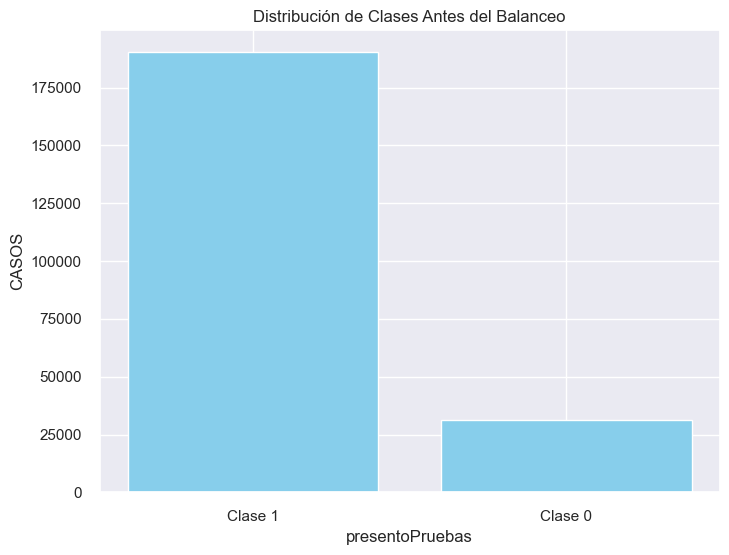

In [110]:
plt.figure(figsize=(8, 6))
counter = Counter(y)
plt.bar(counter.keys(), counter.values(), color='skyblue')
plt.xlabel('presentoPruebas')
plt.ylabel('CASOS')
plt.title('Distribución de Clases Antes del Balanceo')
plt.xticks(np.arange(len(counter)), [f'Clase {i}' for i in counter.keys()])
plt.show()

Submuestreo

Se define la técnica de submuestreo: reducir la clase mayoritaria.

In [111]:
under = RandomUnderSampler(sampling_strategy='auto')
X_b, y_b = under.fit_resample(X, y)

Se crea un dataframe completo balanceado **df_b**

In [112]:
df_b = pd.concat([X_b, y_b], axis=1)

Gráfico de la distribución de clases después del balanceo con RandomUnderSampler

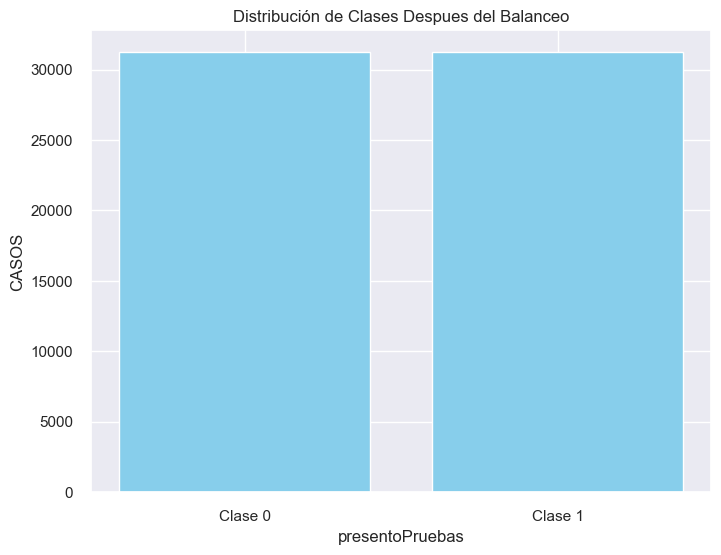

In [113]:
plt.figure(figsize=(8, 6))
counter = Counter(y_b)
plt.bar(counter.keys(), counter.values(), color='skyblue')
plt.xlabel('presentoPruebas')
plt.ylabel('CASOS')
plt.title('Distribución de Clases Despues del Balanceo')
plt.xticks(np.arange(len(counter)), [f'Clase {i}' for i in counter.keys()])
plt.show()

In [114]:
df_b.to_csv('factores_narino_balanceado.csv')

## 6.6. Entrenamiento del modelo

Se inicia los entrenamientos del modelo

In [115]:
df_b.columns

Index(['cole_bilingue', 'estu_horas_trabaja', 'estu_puesto',
       'fami_personas_hogar', 'fami_servicio_television', 'cole_calendario_A',
       'cole_calendario_B', 'cole_calendario_F',
       'cole_caracter_tecnico_academico', 'cole_caracter_tecnico',
       'cole_caracter_academico', 'cole_caracter_normalista',
       'cole_jornada_mañana', 'cole_jornada_tarde', 'cole_jornada_noche',
       'cole_jornada_unica', 'cole_jornada_sabatina',
       'cole_jornada_sabatina_dominical', 'estu_genero_f', 'estu_genero_m',
       'presentoPruebas'],
      dtype='object')

In [116]:
from sklearn.feature_selection import chi2
import numpy as np

chi2_vals, p_vals = chi2(X_b, y_b.astype("category").cat.codes)
result = pd.DataFrame({"Variable": X.columns, "p-value": p_vals, "chi2": chi2_vals})
print(result.sort_values("p-value"))

                           Variable        p-value          chi2
1                estu_horas_trabaja   0.000000e+00   5900.506688
2                       estu_puesto   0.000000e+00  35098.251240
6                 cole_calendario_B   0.000000e+00   4321.967486
14               cole_jornada_noche  1.082572e-298   1364.510440
15               cole_jornada_unica  3.110935e-216    985.100562
5                 cole_calendario_A  2.138218e-202    921.444742
7                 cole_calendario_F  7.763936e-112    505.000000
4          fami_servicio_television  1.739619e-111    503.389658
16            cole_jornada_sabatina  1.468868e-109    494.535341
12              cole_jornada_mañana  1.310444e-102    462.593894
9             cole_caracter_tecnico   2.646524e-77    346.346853
11         cole_caracter_normalista   4.546531e-63    281.000000
3               fami_personas_hogar   8.559678e-31    133.108649
10          cole_caracter_academico   2.784860e-29    126.196571
0                     col

In [117]:
result = result[(result['p-value'] < 0.09) & (result['chi2'] > 48)]['Variable']

In [118]:
Variables = result.to_list()

In [119]:
Variables

['estu_horas_trabaja',
 'estu_puesto',
 'fami_personas_hogar',
 'fami_servicio_television',
 'cole_calendario_A',
 'cole_calendario_B',
 'cole_calendario_F',
 'cole_caracter_tecnico',
 'cole_caracter_academico',
 'cole_caracter_normalista',
 'cole_jornada_mañana',
 'cole_jornada_noche',
 'cole_jornada_unica',
 'cole_jornada_sabatina']

In [120]:
Markdown(f'La prueba indica que se debe trabajar el modelo con las variables: **{", ".join(Variables[:-1])} y {Variables[-1]}**.')

La prueba indica que se debe trabajar el modelo con las variables: **estu_horas_trabaja, estu_puesto, fami_personas_hogar, fami_servicio_television, cole_calendario_A, cole_calendario_B, cole_calendario_F, cole_caracter_tecnico, cole_caracter_academico, cole_caracter_normalista, cole_jornada_mañana, cole_jornada_noche, cole_jornada_unica y cole_jornada_sabatina**.

In [121]:
exp = setup(
    data=df_b,
    target='presentoPruebas',   # variable objetivo
    session_id=123,            # semilla reproducible
    normalize=True,            # normaliza variables
    categorical_features = Variables, # PyCaret detecta automáticamente
       fix_imbalance=False
)


,Description,Value
0,Session id,123
1,Target,presentoPruebas
2,Target type,Binary
3,Original data shape,"(62446, 21)"
4,Transformed data shape,"(62446, 41)"
5,Transformed train set shape,"(43712, 41)"
6,Transformed test set shape,"(18734, 41)"
7,Numeric features,6
8,Categorical features,14
9,Preprocess,True


Se evaluan los modelos con validación cruzada y guardamos el mejor modelo en la variable **best**

In [122]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8138,0.8824,0.8994,0.7680,0.8285,0.6277,0.6371,2.7290
lr,Logistic Regression,0.8135,0.8807,0.8945,0.7699,0.8275,0.6271,0.6355,1.9640
lightgbm,Light Gradient Boosting Machine,0.8135,0.8816,0.8931,0.7704,0.8272,0.6269,0.6351,0.9180
ridge,Ridge Classifier,0.8132,0.8799,0.8888,0.7722,0.8264,0.6265,0.6338,0.5790
lda,Linear Discriminant Analysis,0.8132,0.8799,0.8888,0.7722,0.8264,0.6265,0.6338,0.6630
ada,Ada Boost Classifier,0.8127,0.8799,0.8922,0.7699,0.8265,0.6254,0.6335,1.3200
svm,SVM - Linear Kernel,0.8077,0.8554,0.8959,0.7621,0.8232,0.6155,0.6262,0.7980
rf,Random Forest Classifier,0.8052,0.8686,0.8781,0.7665,0.8185,0.6105,0.6171,2.3570
et,Extra Trees Classifier,0.8032,0.8619,0.8664,0.7692,0.8149,0.6064,0.6114,2.9290
dt,Decision Tree Classifier,0.8024,0.8576,0.8643,0.7692,0.8140,0.6049,0.6096,0.6740


Se crea el modelo **Gradient Boosting Classifier**

In [123]:
gbc_model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8239,0.8914,0.9076,0.7774,0.8375,0.6478,0.6570
1,0.8111,0.8827,0.8939,0.7669,0.8255,0.6221,0.6309
2,0.8156,0.8847,0.8998,0.7702,0.8300,0.6312,0.6403
3,0.8106,0.8745,0.8980,0.7644,0.8258,0.6211,0.6308
4,0.8135,0.8851,0.8957,0.7694,0.8277,0.6271,0.6357
5,0.8076,0.8803,0.9012,0.7592,0.8241,0.6152,0.6262
6,0.8151,0.8838,0.8929,0.7727,0.8285,0.6303,0.6381
7,0.8099,0.8692,0.8984,0.7632,0.8253,0.6198,0.6297
8,0.8140,0.8867,0.9039,0.7661,0.8293,0.6280,0.6384


Se evalua el modelo con graficos

In [ ]:
evaluate_model(gbc_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Se afinan  los hiperparámetros del modelo

In [125]:
tuned_gbc = tune_model(gbc_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8253,0.8898,0.9012,0.7824,0.8376,0.6505,0.6581
1,0.8108,0.8832,0.8866,0.7700,0.8242,0.6217,0.6289
2,0.8147,0.8838,0.8916,0.7728,0.8280,0.6294,0.6369
3,0.8081,0.8731,0.8934,0.7632,0.8232,0.6161,0.6253
4,0.8147,0.8838,0.8898,0.7737,0.8277,0.6294,0.6366
5,0.8103,0.8795,0.8994,0.7635,0.8259,0.6207,0.6307
6,0.8190,0.8831,0.8888,0.7799,0.8308,0.6381,0.6444
7,0.8097,0.8686,0.8934,0.7652,0.8243,0.6193,0.6282
8,0.8124,0.8847,0.8975,0.7669,0.8271,0.6248,0.6341


Fitting 10 folds for each of 10 candidates, totalling 100 fits


Se finaliza el modelo entrenado para su uso

In [126]:
final_gbc = finalize_model(tuned_gbc)

Predecir sobre el conjunto total o un muestreo

In [127]:
predicciones = predict_model(final_gbc, data=df_b)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Gradient Boosting Classifier,0.8162,0.8858,0.8859,0.7776,0.8282,0.6325,0.6387


Mostrar primeras predicciones

In [128]:
print(predicciones.head())

        cole_bilingue  estu_horas_trabaja estu_puesto  fami_personas_hogar  \
75195               0                   0           0                    5   
79012               0                   0           4                    6   
74345               0                   0           4                    4   
189741              0                   0           4                    6   
125860              0                   0           4                    4   

        fami_servicio_television  cole_calendario_A  cole_calendario_B  \
75195                          1                  1                  0   
79012                          0                  1                  0   
74345                          0                  0                  0   
189741                         0                  0                  1   
125860                         1                  1                  0   

        cole_calendario_F  cole_caracter_tecnico_academico  \
75195                   